### Hugo Englund | 2020-12-19

# Laboration 6: Part A
### Outline
In this laboration we want to explore the Q-learning algorithm. This will be done by the examining the Cartpole problem in terms of: 
1. Impact of the hyperparameters on the agent's performance.
2. Analysis of Q-tables.
3. Impact of adaptive learning rate as well as epsilon.


## Set up the Colab environment
*Code provided by Tomas Nordström and Kalle Prorok.*

This uses the CartPole environment from OpenAI's gym: https://gym.openai.com/ or more specificly: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py (Note that this is a Bang-Bang controller with no neutral operation, that is, it either moves left of it moves right in each time step). The original code from a paper by Sutton can be found at http://incompleteideas.net/sutton/book/code/pole.c


In [ ]:
WithAnimations = True

In [ ]:
if WithAnimations:
# This is needed to get animations working in colab
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 252 kB in 1s (169 kB/s)
Reading package lists... Done
Building dependency tree       
Readin

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import os
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from numpy import argmax

# Matlab plotting
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# To plot pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
# For this Lab
import random
import gym

TensorFlow version: 2.4.0
Keras version: 2.4.0


In [ ]:
# Test for GPU and determine what GPU we have
# Could also use https://github.com/anderskm/gputil
import sys
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
    !nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-9d320edc-bbe9-2ae9-cba0-44ac208e311b)


## Create environment


In [ ]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Let's initialize the environment by calling is reset() method. This returns an observation:
env.seed(42)
obs = env.reset()

Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


## Animation support

In [ ]:
if WithAnimations:
  try:
      import pyvirtualdisplay
      display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
  except ImportError:
      pass
  print("WithAnimations =", env.render())

WithAnimations = True


In [ ]:
if WithAnimations:
  def plot_environment(env, figsize=(5,4)):
      plt.figure(figsize=figsize)
      img = env.render(mode="rgb_array")
      plt.imshow(img)
      plt.axis("off")
      return img

In [ ]:
if WithAnimations:
    def update_scene(num, frames, patch):
        patch.set_data(frames[num])
        return patch,

    def plot_animation(frames, repeat=False, interval=40):
        fig = plt.figure()
        patch = plt.imshow(frames[0])
        plt.axis('off')
        anim = animation.FuncAnimation(
            fig, update_scene, fargs=(frames, patch),
            frames=len(frames), repeat=repeat, interval=interval)
        plt.close()
        return anim
else:
    # Define a dummy function in case we do not want animations
    # We seems unable to have "if WithAnimations:" around a call to "animation.FuncAnimation()"???
    def plot_animation(frames, repeat=False, interval=40):
        return True

## Set up experiment

In [ ]:
# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is too little
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10 

### Define functions
Define some methods for training our agent, plotting etc.


In [ ]:
# Map a 4-dimensional state into a state index
# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation, DISCRETE_STEPS):
    """ Map a 4-dimensional state into a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state

In [ ]:
def train_agent(EPISODES, EPSILON, GAMMA, LEARNING_RATE, DISCRETE_STEPS, PRINT):
    '''
        trains the agent for the given parameters
        and returns the Q-table and the episode rewards
    '''
    # Initialise statistics to zero
    average_cumulative_reward = 0.0
    episode_reward = np.zeros(EPISODES)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Loop over episodes
    for i in range(EPISODES):
        state4D = env.reset()
        state = make_state(state4D, DISCRETE_STEPS)

        terminate = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)


            # Sometimes, the agent takes a random action, to explore the environment
            if random.random() < EPSILON:
                action = random.randrange(2)
            else:
                action = greedy_action

            # Perform the action
            obs, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(obs, DISCRETE_STEPS)

            # Update the Q-Table
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LEARNING_RATE * td_error

            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward
        
        # Per-episode statistics
        if ((i % 500)==0 and PRINT):
            print(i, cumulative_reward, sep=',')

    return qtable, episode_reward

In [ ]:
def plot_reward(episode_reward):
    '''
        plots episode reward along with
        the running episode mean
    '''
    plt.figure(figsize=(16, 4))
    plt.plot(episode_reward,"b")
    y_av = running_mean(episode_reward, N=100)
    plt.plot(y_av,"r")
    plt.show()

In [ ]:
def get_frames(qtable):
    '''
        builds the frame for animation
    '''

    frames = []
    # Animate a run with current qtable
    # env.seed(42)

    # Reset cart and get an initial state
    state = make_state(env.reset(), 12) 

    for step in range(200):
        # From the state find an action
        qvalues = qtable[state]
        action = argmax(qvalues) # greedy action
        # Perform an action to the environment
        next_state, reward, terminate, info = env.step(action)
        state = make_state(next_state, 12)

        if terminate:
            break
        img = env.render(mode="rgb_array")
        frames.append(img)

    return frames

### Experiment with the hyperparameters
First, we experiment with the hyperparameters to see their impact on the agent's performance. Besides the four parameters in the state information - cart velocity, angular velocity, pendulum angle and horizontal position - we consider the hyperparameters in the Bellman equation. Then, we go further by implementing learning rate as well as epsilon decay.

#### Vary number of episodes
We test a few settings of different, all else constant:

In [ ]:
# parameters
EPISODES       = [5000, 10000, 15000, 20000]  # Number of eposides to run, org. val = 15000
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed

Number of episodes: 5000
Q-table = 20736 x 2


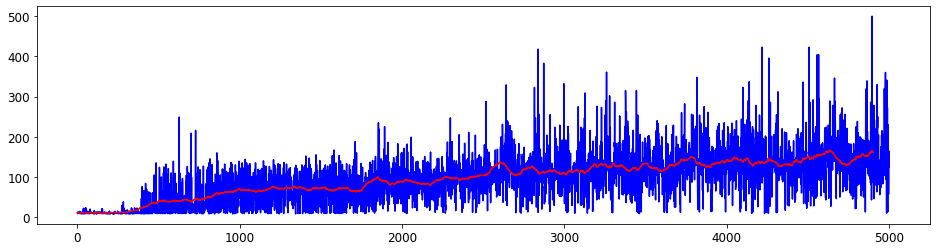

Number of episodes: 10000
Q-table = 20736 x 2


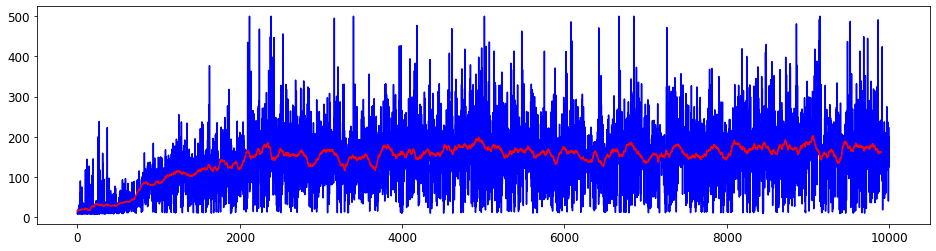

Number of episodes: 15000
Q-table = 20736 x 2


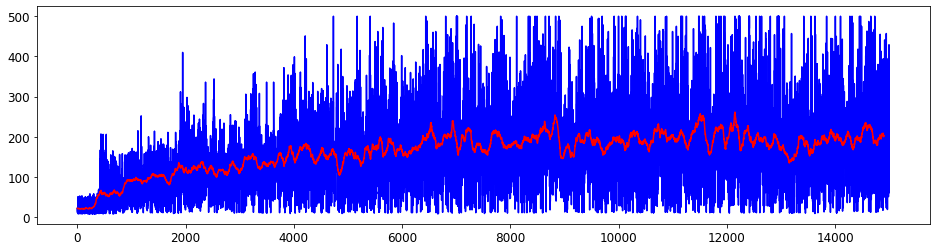

Number of episodes: 20000
Q-table = 20736 x 2


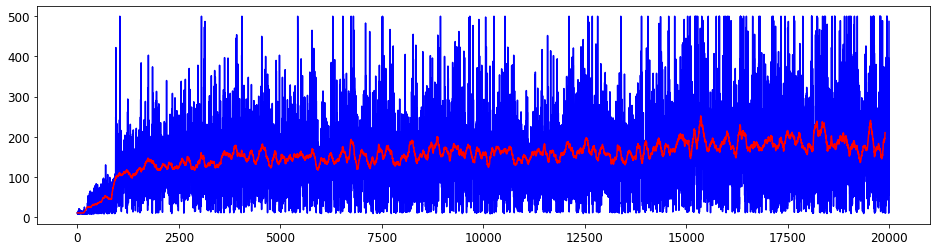

In [ ]:
for episode in EPISODES:
    print('Number of episodes: {}'.format(episode))
    q, r = train_agent(episode, EPSILON, GAMMA, LEARNING_RATE, DISCRETE_STEPS, PRINT)
    plot_reward(r)

From this it seems lika we can expect better performance as the episodes inreases. We can conclude that a number of episodes varying between 15000 and 20000 is suitable since we obtain a higher average reward towards the end, which is not yet obtained for 5000 and 10000 episodes. 
___


#### Vary the epsilon
We test a few different settings of epsilon, all else constant:

In [ ]:
# parameters
EPISODES       = 15000  # Number of eposides to run, org. val = 15000
EPSILON        = [0.05, 0.1, 0.25, 0.5]   # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed

Value of epsilon: 0.05
Q-table = 20736 x 2


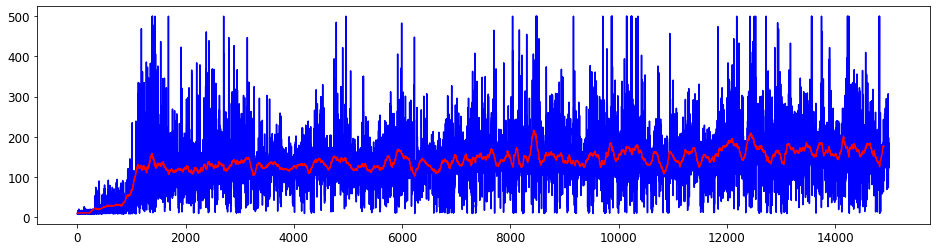

Value of epsilon: 0.1
Q-table = 20736 x 2


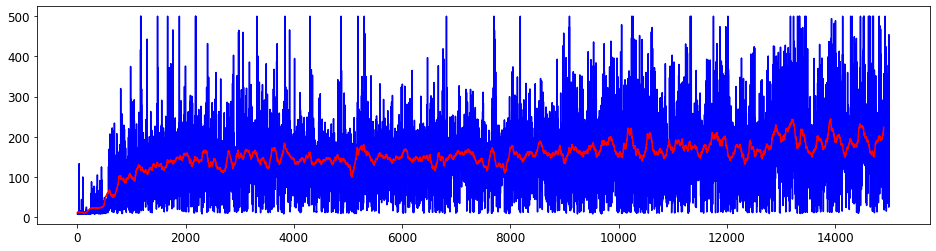

Value of epsilon: 0.25
Q-table = 20736 x 2


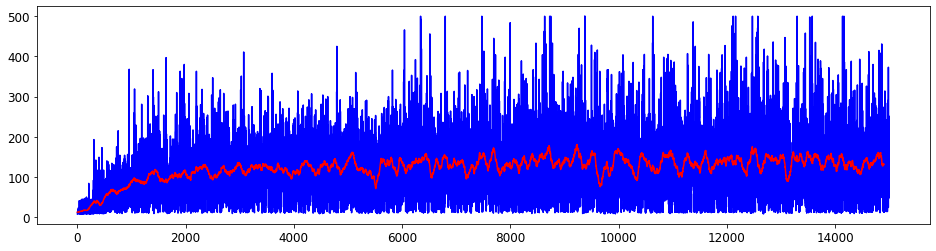

Value of epsilon: 0.5
Q-table = 20736 x 2


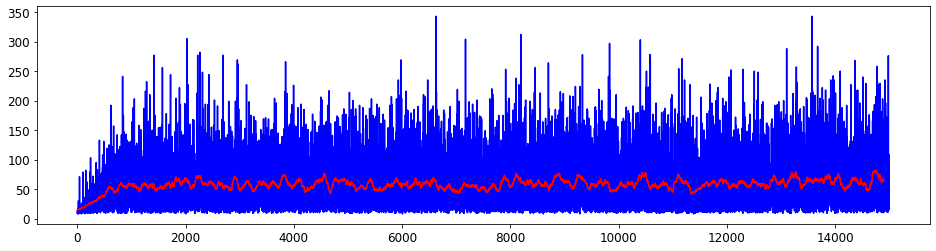

In [ ]:
for epsilon in EPSILON:
    print('Value of epsilon: {}'.format(epsilon))
    q, r = train_agent(EPISODES, epsilon, GAMMA, LEARNING_RATE, DISCRETE_STEPS, PRINT)
    plot_reward(r)

We can clearly see that an epsilon somewhere between 0.05 and 0.25 is suitable, and the choice of 0.1 seems best under these circumstances.
___

#### Vary the gamma
We test a few different settings of gamma, all else constant:

In [ ]:
# parameters
EPISODES       = 15000  # Number of eposides to run, org. val = 15000
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = [0.5, 0.75, 0.9]    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed

Value of gamma: 0.5
Q-table = 20736 x 2


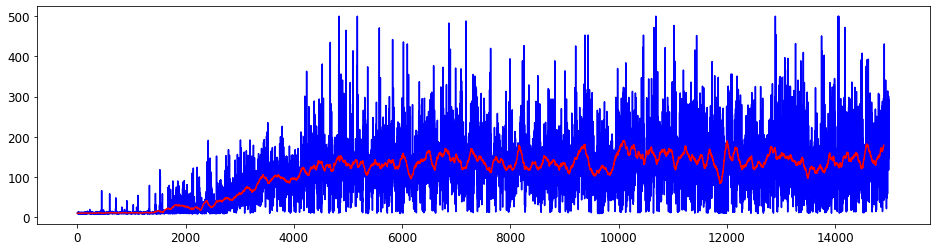

Value of gamma: 0.75
Q-table = 20736 x 2


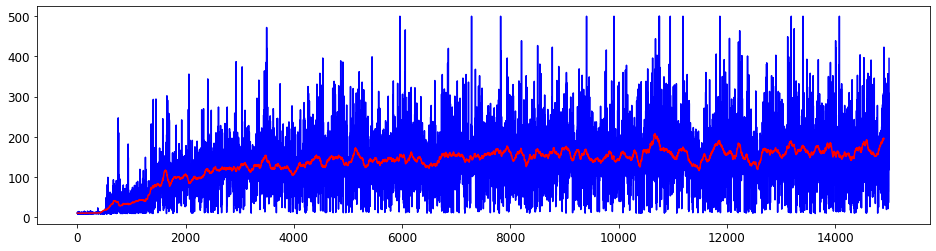

Value of gamma: 0.9
Q-table = 20736 x 2


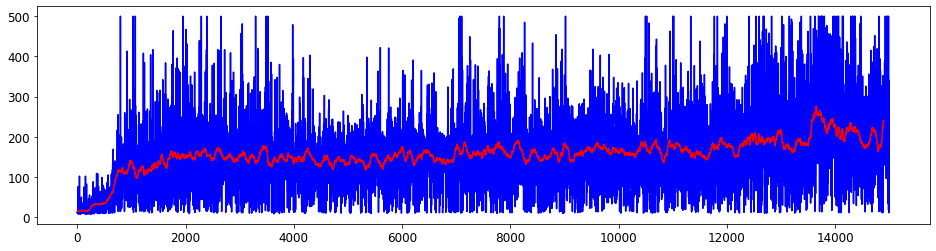

In [ ]:
for gamma in GAMMA:
    print('Value of gamma: {}'.format(gamma))
    q, r = train_agent(EPISODES, EPSILON, gamma, LEARNING_RATE, DISCRETE_STEPS, PRINT)
    plot_reward(r)

The effect of gamma is not evident, but we can conclude that a gamma relatively close to 1 is suitable since we perform better as gamma increases. However, the difference between 0.75 and 0.90 is not that large.
____

#### Vary the learning rate
We test a few different settings of learning rates, all else constant:

In [ ]:
# parameters
EPISODES       = 15000  # Number of eposides to run, org. val = 15000
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9   # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = [0.25, 0.1, 0.05, 0.01]    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed

Learning rate: 0.25
Q-table = 20736 x 2


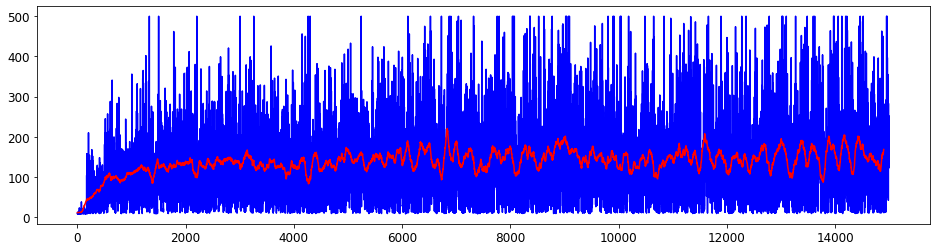

Learning rate: 0.1
Q-table = 20736 x 2


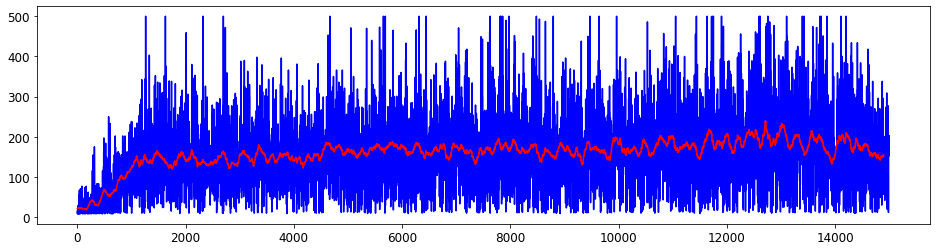

Learning rate: 0.05
Q-table = 20736 x 2


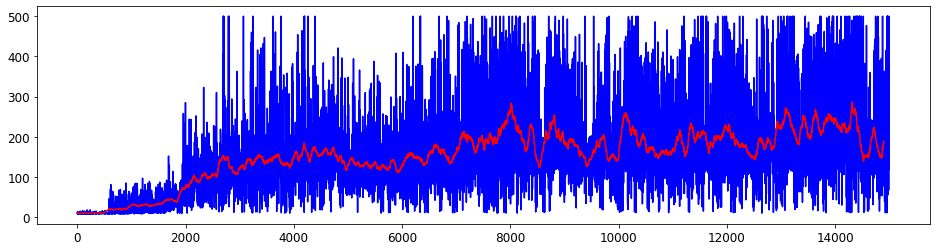

Learning rate: 0.01
Q-table = 20736 x 2


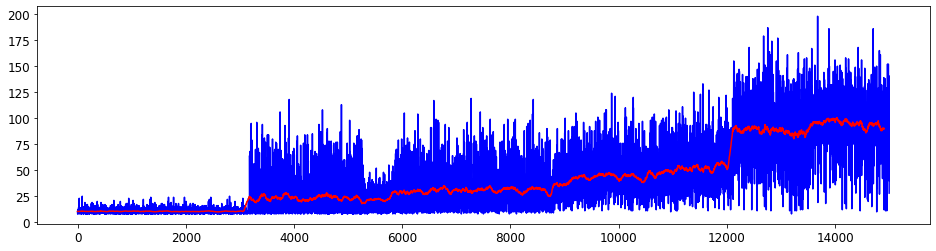

In [ ]:
for lr in LEARNING_RATE:
    print('Learning rate: {}'.format(lr))
    q, r = train_agent(EPISODES, EPSILON, GAMMA, lr, DISCRETE_STEPS, PRINT)
    plot_reward(r)

Form this we can see that the learning rate should not be to small, since a learning rate of 0.01 decreased performance drastically while those equal and above 0.05 were significantly better.
___




#### Vary the discretization steps
We test a few different settings of discretization steps, all else constant:

In [ ]:
# parameters
EPISODES       = 15000  # Number of eposides to run, org. val = 15000
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9   # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = [8, 10, 12]     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed

Dicretization steps per state: 8
Q-table = 4096 x 2


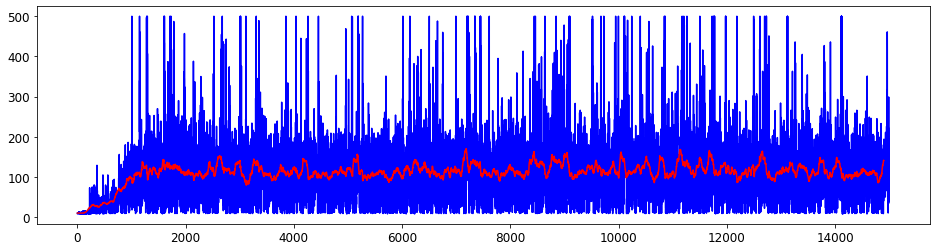

Dicretization steps per state: 10
Q-table = 10000 x 2


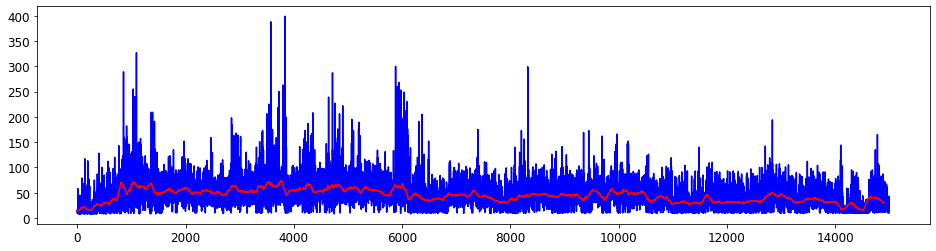

Dicretization steps per state: 12
Q-table = 20736 x 2


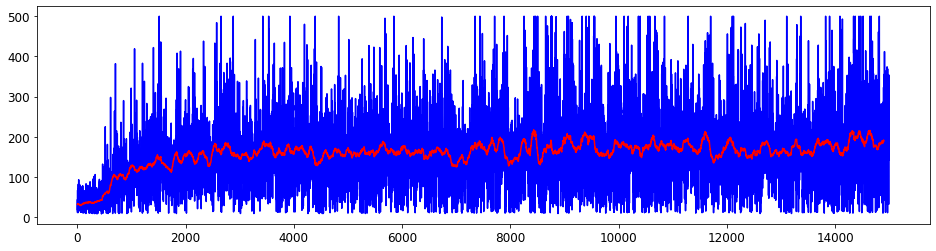

In [ ]:
for steps in DISCRETE_STEPS:
    print('Dicretization steps per state: {}'.format(steps))
    q, r = train_agent(EPISODES, EPSILON, GAMMA, LEARNING_RATE, steps, PRINT)
    plot_reward(r)

Fo the discreatization steps there is no clear pattern since 8 steps was clearly better than 10, while 12 was superior. We prefer to have a higher number of steps, but we have to consider the tradeoff between more steps and the increasing size of the Q-table. 
____

### Stability analysis
Now, we make three separate runs with the same parameter settings to investigate the stability of the results. We can note that there are random aspects in the model, and thus we can expect some variability in the results. 

In [ ]:
# parameters
EPISODES       = 15000  # Number of eposides to run, org. val = 15000
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
PRINT          = False  # Determine if cumulative episode rewards should be printed

Run number: 1
Q-table = 20736 x 2


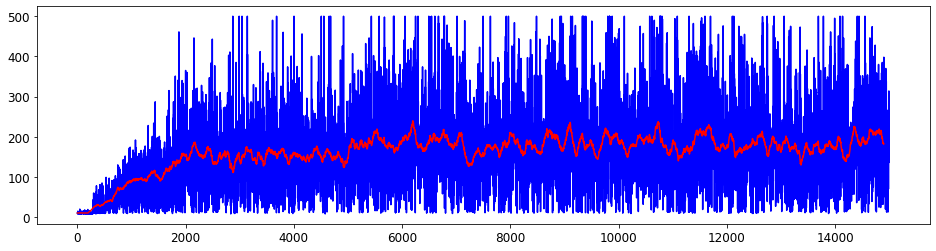

Run number: 2
Q-table = 20736 x 2


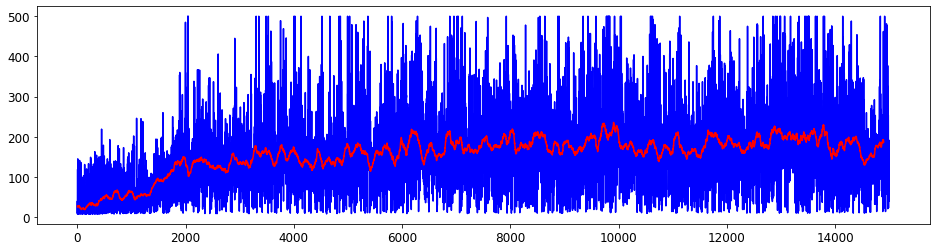

Run number: 3
Q-table = 20736 x 2


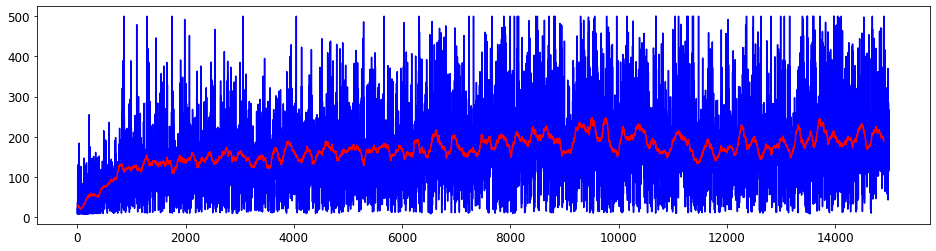

In [ ]:
# save Q-tables for further analysis
q_tables = []
for run in range(3):
    print('Run number: {}'.format(run + 1))
    q, r = train_agent(EPISODES, EPSILON, GAMMA, LEARNING_RATE, DISCRETE_STEPS, PRINT)
    q_tables.append(q)
    plot_reward(r)

As expected, there are some differences in between the runs but overall the performance is quite stable.
____

### Q-table analysis
Further, we analyze some of the Q-tables from the previous runs to determine why our performance is so poor.

In [ ]:
# convert some Q-tables to numpy arrays
Q_tables = np.array(q_tables)          

#### Check unexplored states
We can examine the proportion of unexplored states to determine if this is a aspect of the mediocre performance:

In [ ]:
# check how many zeros there are in each
# Q-table, e.g. proportion of unexplored states
for table in Q_tables:
    print('Proportion of unexplored states: {}%\n'.format(round(np.mean(table == 0) * 100, 2)))

Proportion of unexplored states: 98.26%

Proportion of unexplored states: 98.29%

Proportion of unexplored states: 98.3%



In all three cases we have approximately 98% unexplored states. This as an clear indicator of a too greedy agent, e.g. one that favors exploitation over exploring. If we relate this to hyperparameter epsilon, we can draw the conclusion that it is too low. On the contrary, we earlier concluded that a epsilon higher than 0.1 is inappropriate. Due to this, we can derive that a dynamic epsilon is a possible solution. Thus, we might improve by adding a decay to the epsilon so we can explore more states initally, and exploit more towards the later episodes. By this approach we can also expect a more stable system since the agent, in the early episodes, explores the poor strategies and hopefully learns to neglect these in the future episodes, i.e. increase the baseline performance.

Moreover, we can apply similar reasoning for the learning rate (alpha). Since we start off at random point in the solution space we prefer to take large steps towards the solution initially, and as we approach the optimum we want to take much smaller steps in order to ultimately converge. Thus, learning rate decay is another relevant performance enhancer generally as well as in our problem. 

Further, one could argue that our state space is too large since we have a lot of unexplored states. On the other hand, if it would be smaller, we would decrease the number of possible strategies and hence miss out on the opportunity to improve further.

___

### Alpha and epsilon decay
We modify our method for training the agent with alpha and epsilon decay. For epsilon we use a decay rate of 0.9995 applied in each episode. For each episode alpha is updated by

$$
\alpha = \frac{\alpha_0}{1 + t\cdot d}
$$ 

where $\alpha_0 = 0.5$ is the inital learning rate, $t$ is the current episode and $d = 0.001$ is the decay factor. Implemented as follows:

In [ ]:
def train_agent_decay(EPISODES, EPSILON, GAMMA, LEARNING_RATE, DISCRETE_STEPS, ALPHA_DECAY, PRINT):
    '''
        trains the agent for the given parameters
        and returns the Q-table and the episode rewards
    '''
    # Initialise statistics to zero
    average_cumulative_reward = 0.0
    episode_reward = np.zeros(EPISODES)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Decay settings
    MIN_EPSILON = 0.01
    MIN_LR = 0.01

    # Loop over episodes
    for i in range(EPISODES):
        state4D = env.reset()
        state = make_state(state4D, DISCRETE_STEPS)

        terminate = False
        cumulative_reward = 0.0
  
        # decrease epsilon
        EPSILON = max(EPSILON * 0.9995, MIN_EPSILON)

        # decrease learning rate
        alpha = max(LEARNING_RATE / (1 + i * ALPHA_DECAY), MIN_LR)

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment
            if random.random() < EPSILON:
                action = random.randrange(2)
            else:
                action = greedy_action

            # Perform the action
            obs, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(obs, DISCRETE_STEPS)

            # Update the Q-Table
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += alpha * td_error

            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward
        
        # Per-episode statistics
        if ((i % 500) == 0 and PRINT):
            print(i, cumulative_reward, sep=',')

    return qtable, episode_reward

#### Fine-tune hyperparameters

In [ ]:
# hyperparameters
EPISODES       = 15000  # Number of eposides to run, org. val = 15000
EPSILON        = 0.8    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.5    # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10
ALPHA_DECAY    = 0.001  # Learning rate decay
PRINT          = True   # Determine if cumulative episode rewards should be printed

In [ ]:
q, r = train_agent_decay(EPISODES, EPSILON, GAMMA, LEARNING_RATE, DISCRETE_STEPS, ALPHA_DECAY, PRINT)

Q-table = 20736 x 2
0,15.0

500,32.0

1000,23.0

1500,87.0

2000,81.0

2500,125.0

3000,180.0

3500,55.0

4000,248.0

4500,188.0

5000,200.0

5500,192.0

6000,150.0

6500,272.0

7000,123.0

7500,161.0

8000,163.0

8500,198.0

9000,264.0

9500,170.0

10000,213.0

10500,207.0

11000,182.0

11500,168.0

12000,143.0

12500,240.0

13000,428.0

13500,293.0

14000,144.0

14500,214.0



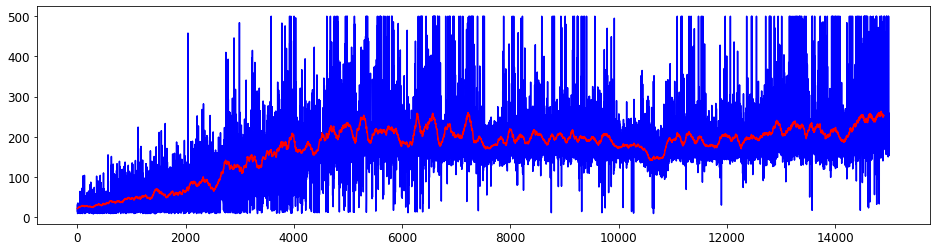

In [ ]:
# visualize the cumulative rewards
plot_reward(r)

In [ ]:
# visualize agent's performance by animation
f = get_frames(q)
plot_animation(f)

By implementing adaptive alpha and espilon, combined with some fine-tuning of the hyperparameters we have now obtained a much better model. We have clearly shifted from the baseline with singificantly fewer low rewards towards the later episodes, as well as quite stable results through all episodes. In addition, we also, at average, obtain higher rewards. 

We can analyze the corresponding Q-table for this model:

In [ ]:
print("Proportion of unexplored states:")
print(round(np.mean(np.array(q) == 0) * 100, 2), '%')

Proportion of unexplored states:
98.6 %


We have the same magnitude of unexplored states as before, but we have clearly improved. This can be summarized in that our agent is making smarter choice than before. Initally, it explores much more due to higher initial epsilon, and it is more generous when valuating the different action due to the higher initial alpha. Therefore, we do not necessary have to explore more of the state space to improve. Instead, we must explore in a smart way. 
___